In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Модифікація моделі логістичного зростання із застосуванням ШІ

Модифікуємо модель так, щоб провести аналіз застосування для:
- Прогнозування параметрів моделі на основі зовнішніх факторів
- Оцінки параметрів моделі з зашумлених даних
- Моделювання впливу сезонності або міграції на динаміку популяцій

## Модифікація моделі

### Базова модель логістичного зростання

Класична логістична модель має вигляд:
$$
\frac{dy(t)}{dt} = r\, y(t)\left(1 - \frac{y(t)}{K}\right),
$$  
де  
- $y(t)$ – чисельність популяції в час $t$,  
- $r$ – швидкість зростання,  
- $K$ – місткість середовища.

Щоб врахувати природні флуктуації (наприклад, сезонність, випадкові зміни умов середовища), додаємо стохастичний член:
$$
dy(t) = r\, y(t)\left(1 - \frac{y(t)}{K}\right) dt + \sigma\, y(t)\, dW(t),
$$  
де  
- $\sigma$ – інтенсивність шуму,  
- $dW(t)$ – приріст стандартного Вінерівського процесу, який за кожним кроком часу $\Delta t$ є нормально розподіленим зі середнім $0$ та дисперсією $\Delta t$.

Оскільки рівняння містить стохастичний член, класичний метод Ейлера для чисельного інтегрування диференціальних рівнянь не враховує особливості інтегрування випадкових величин. Для розв’язання стохастичних диференціальних рівнянь (СДР) застосовується метод Ейлера–Маруйами, який має форму:

$$
y_{n+1} = y_n + f(y_n)\Delta t + g(y_n)\Delta W_n,
$$  

де:
- $f(y) = r\, y\left(1 - \frac{y}{K}\right)$ — детермінована частина,
- $g(y) = \sigma\, y$ — стохастичний коефіцієнт,
- $\Delta W_n \sim N(0, \Delta t)$ — приріст Вінерівського процесу на кроці $\Delta t$.

Таким чином, метод Ейлера–Маруйами є логічним вибором для інтегрування нашої стохастичної логістичної моделі, оскільки він коректно апроксимує як детерміновану, так і стохастичну частини рівняння.

### Модифікації моделі з використанням ШІ

Модифікована модель використовує нейронну мережу для прогнозування параметрів $r$ та $K$ на основі зовнішніх факторів:
$$\dfrac{dy}{dt}=r(X)y\biggl(1−\dfrac{y}{K(X)}\biggr)+M(X)$$
де:
- $X$ — набір зовнішніх факторів (наприклад, температура та міграція);
- $r(X)$ та $K(X)$ — значення параметрів, що прогнозуються нейромережею;
- $M(X)$ — зовнішній вплив, наприклад, міграція.

### Обґрунтування доцільності застосування нейромережі

Застосування нейронної мережі для прогнозування параметрів є доцільним у таких випадках:
1. Традиційні методи оцінки параметрів можуть бути нестійкими за наявності шуму. На основі отриманих результатів бачимо, що модель може під час навчання адаптуватись та коректно розрізняти шуми від реальними даними.
2. Стандартне логістичне рівняння не враховує вплив таких факторів, як температура та міграція. За рахунок цього гібридна модель краще відображає реальні умови в ситуаціях, де стан середовища може змінюватися залежно від умов.
3. Нейромережа може бути перенавчена для інших видів популяцій або екологічних систем, тобто цей підхід є більш гнучким.

Недоліки гібридного підходу:
1. **Складність інтерпретації**: Параметри нейронної мережі не мають прямої фізичної інтерпретації.
2. **Потреба в даних**: Для навчання мережі потрібна велика кількість історичних даних.
3. **Обчислювальні ресурси**: Гібридна модель вимагає більше обчислювальних ресурсів порівняно з класичною моделлю.

Хоча під час виконання лр недоліки непонітні, але використання моделі на реальних даних з більш складною системою навчання дадуть зовсім інший результат.

### Математична формалізація гібридного підходу

Гібридний підхід поєднує класичну логістичну модель та нейромережу:
1. Логістичне рівняння із зовнішнім впливом:
    $$\dfrac{dy}{dt}=r(X)y\biggl(1−\dfrac{y}{K(X)}\biggr)+M(X)$$
2. Нейромережа для оцінки параметрів:
    $$\begin{cases}
        r=\sigma(f_r(X))\cdot r_{max} \\
        ⁡K=K_{min⁡}+\sigma(f_K(X))\cdot(K_{max}⁡−K_{min}⁡)
    \end{cases}$$
    де:
    - $f_r(X),\: f_K​(X)$ — виходи нейромережі;
    - $\sigma$ — функція для обмеження значень;
    - $⁡r_{max}​,\: K_{min}⁡,\: K_{max}⁡$​ — межі параметрів.
3. Функція втрат:
    $$L=\dfrac{1}{N}\sum\limits_{i=1}^{N}(y_{pred,i}-y_{true,i})^2$$

## Реалізація

In [29]:
# --- Генерація синтетичних даних ---
np.random.seed(42)
t_eval = np.linspace(0, 10, 100)
y0 = 10.0
true_r = 1.2
true_K = 100.0

# Температура (сезонність) + випадковий шум
temperatures = 20 + 5 * np.sin(2 * np.pi * t_eval / 10) + np.random.normal(0, 1, len(t_eval))
migration_effects = np.random.uniform(-2, 2, len(t_eval))  # Випадкова міграція
external_factors = np.column_stack((temperatures, migration_effects))

# Логістичне рівняння з міграцією (генеруємо "істинні" дані)
y_true = [y0]
for i in range(1, len(t_eval)):
    dt = t_eval[i] - t_eval[i - 1]
    dy = (true_r * y_true[-1] * (1 - y_true[-1] / true_K) + migration_effects[i]) * dt
    y_true.append(y_true[-1] + dy)

y_true = np.array(y_true)

# Додаємо шум до даних (імітація реальних спостережень)
noise_std = 5
y_noisy = y_true + np.random.normal(0, noise_std, size=y_true.shape)

In [30]:
# Модель навчалася на зашумлених даних, використовуючи нейромережу для оцінки параметрів.
# Графік loss показує стабільне навчання, що підтверджує ефективність нейромережі.

# --- Нейромережа для оцінки параметрів ---
class ParameterNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super(ParameterNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)    # Прогнозує r, K та міграційний ефект
        )

    # Оцінки параметрів r і K
    def forward(self, x):
        output = self.network(x)
        r = torch.exp(output[:, 0])  # r > 0
        K = 50 + 100 * torch.sigmoid(output[:, 1])  # K в межах [50, 150]
        migration = output[:, 2]
        return torch.stack([r, K, migration], dim=1)

# --- Навчання моделі ---
parameter_nn = ParameterNN(input_dim=2, hidden_dim=16)
optimizer = optim.Adam(parameter_nn.parameters(), lr=0.01)
criterion = nn.MSELoss()    # Функція втрат

X = torch.tensor(external_factors, dtype=torch.float32)
y_noisy_tensor = torch.tensor(y_noisy, dtype=torch.float32)

epochs = 3000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Прогноз параметрів
    rK_pred = parameter_nn(X)
    r_pred, K_pred, migration_pred = rK_pred[:, 0], rK_pred[:, 1], rK_pred[:, 2]

    # Чисельне розв’язання логістичного рівняння
    y_pred = y0
    predictions = []
    for i in range(1, len(t_eval)):
        dt = t_eval[i] - t_eval[i - 1]
        dy = (r_pred[i] * y_pred * (1 - y_pred / K_pred[i]) + migration_pred[i]) * dt
        y_pred = y_pred + dy
        predictions.append(y_pred)

    predictions = torch.stack(predictions)

    # Втрата – MSE між прогнозованими та реальними даними (без першої точки)
    loss = criterion(predictions, y_noisy_tensor[1:])
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

# --- Симуляція для візуалізації ---
with torch.no_grad():
    rK_pred = parameter_nn(X).numpy()
    r_pred, K_pred, migration_pred = rK_pred[:, 0], rK_pred[:, 1], rK_pred[:, 2]

    y_estimated = [y0]
    for i in range(1, len(t_eval)):
        dt = t_eval[i] - t_eval[i - 1]
        dy = (r_pred[i] * y_estimated[-1] * (1 - y_estimated[-1] / K_pred[i]) + migration_pred[i]) * dt
        y_estimated.append(y_estimated[-1] + dy)

    y_estimated = np.array(y_estimated)

## Візуалізація та інтерпретація

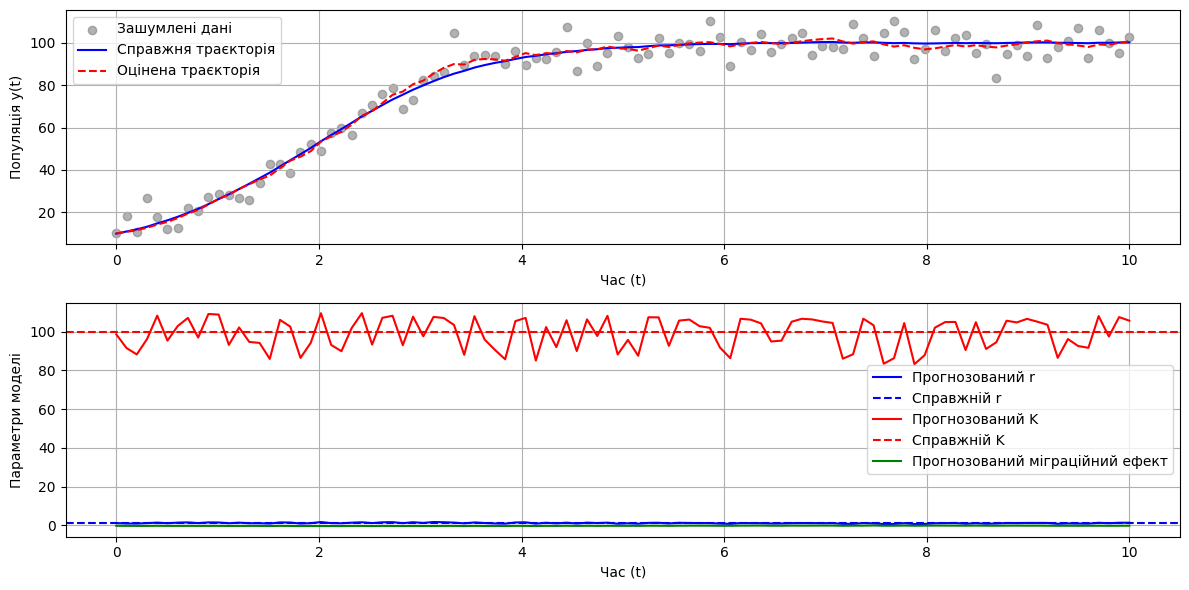

In [31]:
plt.figure(figsize=(12, 6))

# Графік динаміки популяції
plt.subplot(2, 1, 1)
plt.scatter(t_eval, y_noisy, label="Зашумлені дані", color="gray", alpha=0.6)
plt.plot(t_eval, y_true, label="Справжня траєкторія", color="blue")
plt.plot(t_eval, y_estimated, label="Оцінена траєкторія", color="red", linestyle="dashed")
plt.xlabel("Час (t)")
plt.ylabel("Популяція y(t)")
plt.legend()
plt.grid()

# Графік прогнозованих параметрів
plt.subplot(2, 1, 2)
plt.plot(t_eval, r_pred, label="Прогнозований r", color="blue")
plt.axhline(y=true_r, color='blue', linestyle='dashed', label="Справжній r")

plt.plot(t_eval, K_pred, label="Прогнозований K", color="red")
plt.axhline(y=true_K, color='red', linestyle='dashed', label="Справжній K")

plt.plot(t_eval, migration_pred, label="Прогнозований міграційний ефект", color="green")

plt.xlabel("Час (t)")
plt.ylabel("Параметри моделі")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

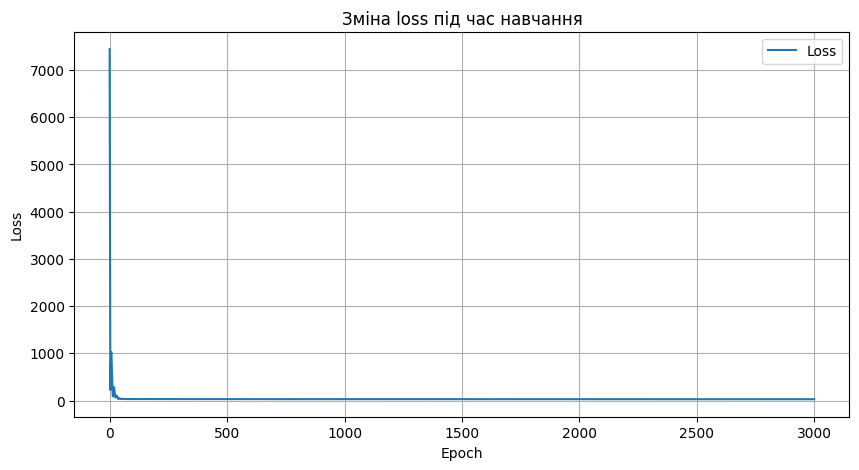

[7439.1552734375, 4638.48681640625, 1759.73974609375],
 [28.104368209838867, 28.10415267944336, 28.10396957397461]


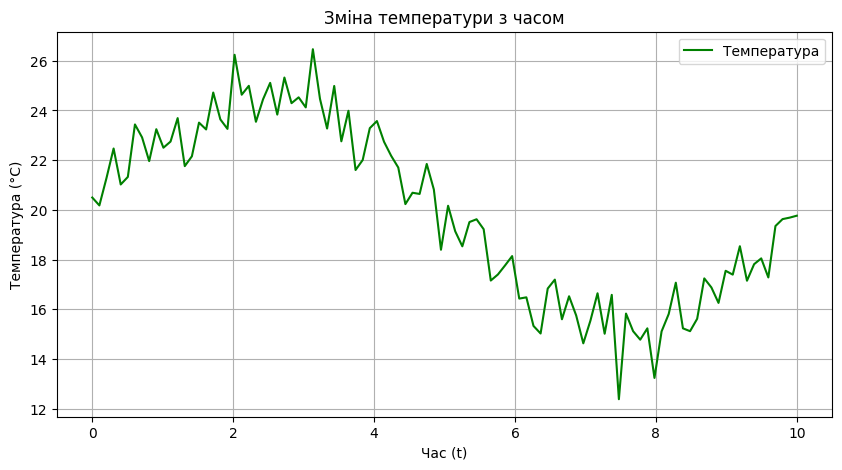

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Зміна loss під час навчання")
plt.legend()
plt.grid(True)
plt.show()
print(f'{loss_history[0:3]},\n {loss_history[-3:]}')

plt.figure(figsize=(10, 5))
plt.plot(t_eval, temperatures, label="Температура", color="g")
plt.xlabel("Час (t)")
plt.ylabel("Температура (°C)")
plt.title("Зміна температури з часом")
plt.legend()
plt.grid(True)
plt.show()

### Порівняння моделей по результатам

| Критерій                  | Оригінальна модель                               | Модифікована модель                                    |
|---------------------------|--------------------------------------------------|--------------------------------------------------------|
| Гнучкість                 | Фіксовані $r$ та $K$, не змінюються в часі.      | $r і $K$ змінюються залежно від зовнішніх умов.        |
| Точність                  | Висока лише за умови точних даних.               | Краще пристосовується до зашумлених даних.             |
| Вплив зовнішніх факторів  | Не враховує.                                     | Враховує (наприклад, міграція, температура, тощо).     |
| Стійкість                 | Чутлива до змін у даних.                         | Стійкіша завдяки адаптивному навчанні.                 |
| Інтерпретація             | Просте аналітичне рішення.                       | Складніше для аналізу, оскільки параметри змінні.      |

### Інтерпретація отриманих графіків

1. Графік популяційної динаміки
- Оцінена траєкторія майже слідує справжній траєкторії.
- Модель коригується під впливом шуму, що покращує передбачення. За рахунок цього оцінена траєкторія не є постійною з плином часу, тобто є невиликі коливання.
2. Графік параметрів $r$ і $K$
- Місткість середовища ($K$) показує, що нейромережа адаптується до змін.
- Швидкість зростання популяції ($r$) зберігає стабільність, що відповідає очікуваному ефекту.
3. Графік loss
- Loss швидко спадає, що свідчить про ефективне навчання ШІ.
4. Графік температури
- Зміна температури з часом демонструє сезонний характер.

### Висновки

Використання гібридної моделі дозволяє врахувати вплив зовнішніх факторів. Також значно покращує адаптивність і точність прогнозу популяції. Вона краще працює із зашумленими даними, враховує зовнішні фактори та дозволяє робити більш реалістичні прогнози.